# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [8]:
!pip install matplotlib
!pip install numpy
!pip install scikit-image
!pip install opencv-python


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy

# Helper functions

In [31]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def get_surf_data(img):
    """
    detect the keypoints and compute using SURF feature extractor with opencv library
    """
    surf = cv2.SURF_create(400)
    kp, des = surf.detectAndCompute(img, None)

    return kp, des

def get_orb_data(img):
    orb = cv2.ORB_create()

    kp = orb.detect(img, None)
    kp, des = orb.compute(img, kp)

    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

### My own testing

In [32]:
img = imread("revised_videos/frames/0679_frames/f0001.jpg")

kp, des = get_orb_data(img)

# Your implementations

In [43]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    # im_result = cv2.drawMatches(img1, kp1, img2, kp2, dist[:num_matches], img2)
    # imshow(im_result)
    
    # matches = sorted(dist, key = lambda x:x.distance)
    argmin = np.argmin(dist, axis=0)

    dist_min = []
    for x in range(argmin.shape[0]):
        dist_min.append(((argmin[x], x) , dist[argmin[x], x]))


    sorted_dist = sorted(dist_min, key=lambda x:x[1])

    final_matches = np.zeros((num_matches, 4))

    for i in range(num_matches):
        i1_pt = sorted_dist[i][0][0]
        i2_pt = sorted_dist[i][0][1]
        final_matches[i] = np.array([kp1[i1_pt].pt[0],kp1[i1_pt].pt[1], kp2[i2_pt].pt[0], kp2[i2_pt].pt[1]])

    # final_matches = [kp1[sorted_dist[i][0][0]].pt[0],kp1[sorted_dist[i][0][0]].pt[1], kp2[sorted_dist[i][0][1]].pt[0], kp2[sorted_dist[i][0][1]].pt[1] for i in range(300)]


    return final_matches

def ransac(match_pairs, num_matches, threshold, p = 0.7, e = 0.25):
    """
    write your ransac code to find the best model, inliers, and residuals
    :param match_pairs: final match pairs from sift or other feature extractor
    :param num_matches: initial match numbers you want to start with, more commonly known as 's'
    :param num_samples:
    :param threshold: 

    """
    # <YOUR CODE>
    #randomly select n points
    min_residual_loss = 2**31 - 1
    N = np.log(1-p) / np.log(1-(1-e)**num_matches)

    best_homography = np.zeros((3,3))
    # best_points = np.zeros((4,4))
    best_num_inliers = -1
    best_inliers = None
    while(N > 0):
        #randomly sample num_matches points
        chosen_points = np.random.choice(match_pairs.shape[0], num_matches)

        #compute homography from that random points
        homography_matrix = compute_homography(match_pairs[chosen_points])


        #use the homography calculated to transform the right image
        homography_matrix = homography_matrix.reshape((3,3))

        local_residual_loss = []
        left_pt_mats = match_pairs[:, :2] # N x 2 left half
        right_pt_mats = match_pairs[:, 2:] # N x 2 right half
        left_pt_mats = np.concatenate([left_pt_mats, np.ones((match_pairs.shape[0], 1))], axis=1) # N x 3 with 1 in the last column
        right_pt_mats = np.concatenate([right_pt_mats, np.ones((match_pairs.shape[0], 1))], axis=1) # N x 3 with 1 in the last column
        left_Hx = homography_matrix@right_pt_mats.T # 3 x N
        left_Hx = left_Hx[:2, :]/left_Hx[2, :]
        local_residual_loss = (np.sqrt(np.sum(np.square(left_pt_mats[:, :2] - left_Hx.T), axis = 1)))

        inliers = local_residual_loss < threshold
        num_inliers = np.sum(inliers)
        #if both inlier and average residual is higher than best, update the best model
        # local_residual_loss = np.average(local_residual_loss)
        # print(f'local residual is {local_residual_loss}')
        if(num_inliers > best_num_inliers):
            min_residual_loss = local_residual_loss
            best_homography = homography_matrix
            # best_points = match_pairs[chosen_points]
            best_num_inliers = num_inliers
            best_inliers = inliers
            
            
        N -= 1

    # return best_homography, min_residual_loss, best_points
    return best_homography, min_residual_loss, best_inliers

def compute_homography(data):
    """
    write your code to compute homography according to the matches
    :param data_n: N-th x,y in the first image and x,y in the second image (4 sets of 1x4 matrix)
    data_1 = [xl, yl, xr, yr]
    data_2 = [xl, yl, xr, yr]
    data_3 = [xl, yl, xr, yr]
    data_4 = [xl, yl, xr, yr]
    """
    # <YOUR CODE>
    # 8 by 3 matrix

    N = data.shape[0]
    Z = np.zeros((N, 1))
    One = np.ones((N, 1))

    A = np.r_[np.c_[Z, Z, Z, -data[:, 2], -data[:, 3], -One, data[:, 1]*data[:, 2], data[:, 1]*data[:, 3], data[:, 1]], 
              np.c_[data[:, 2], data[:, 3], One, Z, Z, Z, -data[:, 0]*data[:, 1], -data[:, 0]*data[:, 2], -data[:, 0]]]

    # A = np.array([[0, 0, 0, -data_1[2], -data_1[3], -1, data_1[1]*data_1[2], data_1[1]*data_1[3], data_1[1]], 
    #           [data_1[2], data_1[3], 1, 0, 0, 0, -data_1[0]*data_1[1], -data_1[0]*data_1[2], -data_1[0]], 
    #           [0, 0, 0, -data_2[2], -data_2[3], -1, data_2[1]*data_2[2], data_2[1]*data_2[3], data_2[1]], 
    #           [data_2[2], data_2[3], 1, 0, 0, 0, -data_2[0]*data_2[1], -data_2[0]*data_2[2], -data_2[0]], 
    #           [0, 0, 0, -data_3[2], -data_3[3], -1, data_3[1]*data_3[2], data_3[1]*data_3[3], data_3[1]], 
    #           [data_3[2], data_3[3], 1, 0, 0, 0, -data_3[0]*data_3[1], -data_3[0]*data_3[2], -data_3[0]], 
    #           [0, 0, 0, -data_4[2], -data_4[3], -1, data_4[1]*data_4[2], data_4[1]*data_4[3], data_4[1]], 
    #           [data_4[2], data_4[3], 1, 0, 0, 0, -data_4[0]*data_4[1], -data_4[0]*data_4[2], -data_4[0]], 
            #   ])
    
    #find the smallest singular value from SVD of A
    U, S, V = np.linalg.svd(A)
    return V[-1, :]

# Main functions

#### Load images

In [44]:
img1 = imread('revised_videos/frames/0679_frames/f0001.jpg')
img2 = imread('revised_videos/frames/2363_frames/f0001.jpg')

#### Part (3) compute and display the initial SIFT matching result

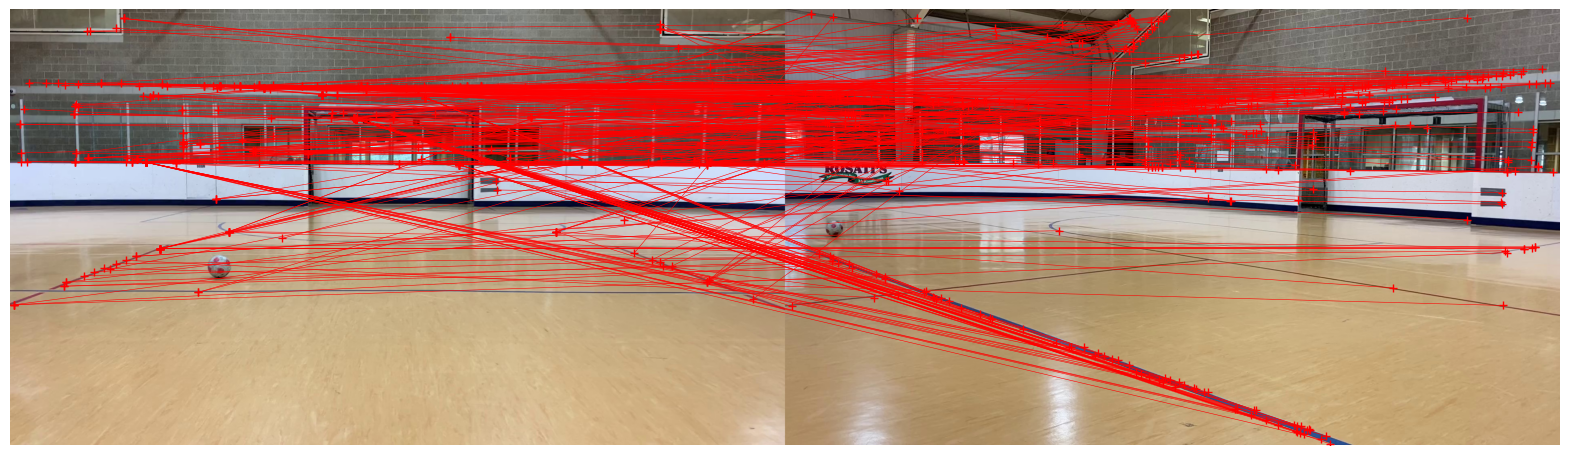

In [54]:
data = get_best_matches(img1, img2, 400)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)

In [55]:
fig.savefig('sift_match.pdf', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

Average residual: 1368.6820076492104
Inliers: 5
inliers shape [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False F

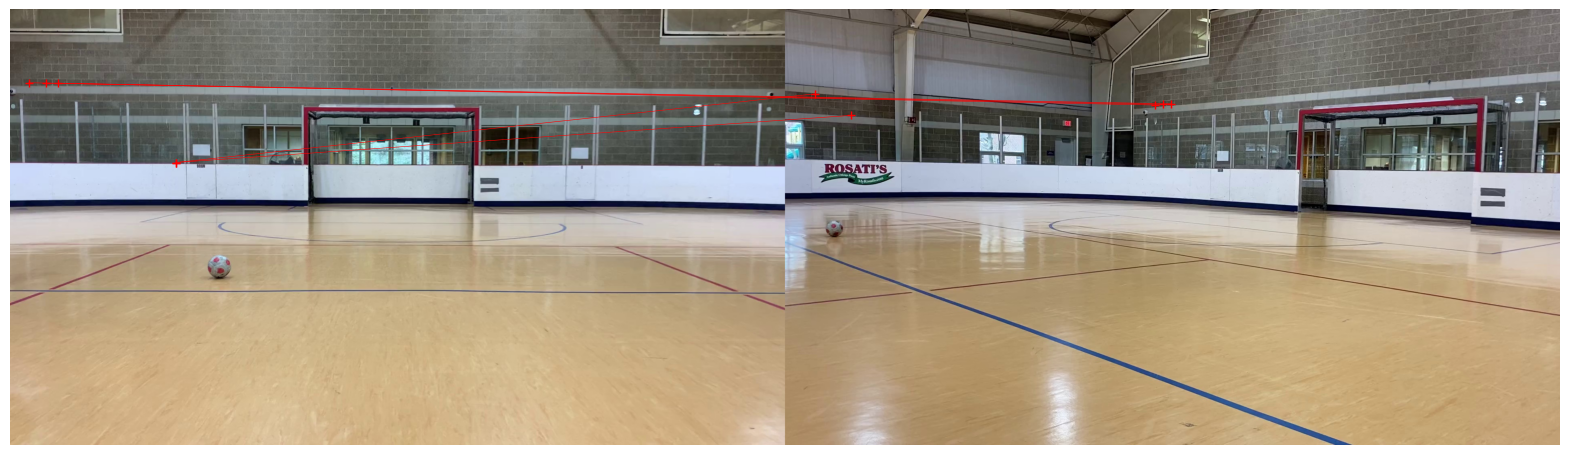

In [66]:
# display the inlier matching, report the average residual
# <YOUR CODE>
homography, residual, inliers = ransac(match_pairs=data, num_matches=6, threshold=30, p=0.9, e=0.20)
# compute_homography(np.array([1,2,3,4]),np.array([1,2,3,4]),np.array([1,2,3,4]),np.array([1,2,3,4]))

print("Average residual:", np.average(residual))
print("Inliers:", np.sum(inliers))
print("inliers shape", inliers)

fig_ransac, ax_ransac = plt.subplots(figsize=(20,10))

plot_inlier_matches(ax_ransac, img1, img2, data[inliers])
fig_ransac.savefig('ransac_match.pdf', bbox_inches='tight')

#### Part (5) warp images to stitch them together

In [168]:
from skimage import transform

# def stitch_images(base_i1_file_name, i2_file_name, homography):
#     img1 = imread(base_i1_file_name)
#     img2 = imread(i2_file_name)

#     new_h = int(img1.shape[0]*1.2)
#     new_w = int(img1.shape[1]*1.8)

#     proj_transform = transform.ProjectiveTransform(homography)
#     warped = transform.warp(img2, proj_transform.inverse, output_shape = (new_h, new_w))
#     warped_mask = warped == 0

#     new_img1 = np.zeros((new_h, new_w, 3))

#     new_img1[0:img1.shape[0], 0:img1.shape[1]] = img1

#     img1 = new_img1

#     img1_masked = img1*warped_mask
#     final_img = img1_masked + warped * 255
#     final_img /= 255

def warp_images(im1, im2, homography):
    """
    write your code to stitch images together according to the homography
    """
    # <YOUR CODE>
    new_h = int(im1.shape[0]*1.2)
    new_w = int(im1.shape[1]*1.8)

    proj_transform = transform.ProjectiveTransform(homography)
    warped = transform.warp(im2, proj_transform.inverse, output_shape = (new_h, new_w))
    warped_mask = warped == 0

    new_im1 = np.zeros((new_h, new_w, 3))

    new_im1[0:im1.shape[0], 0:im1.shape[1]] = im1

    im1 = new_im1

    im1_masked = im1*warped_mask
    final_img = im1_masked + warped * 255
    final_img /= 255
    return final_img
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

final_image = warp_images(img1, img2, homography)

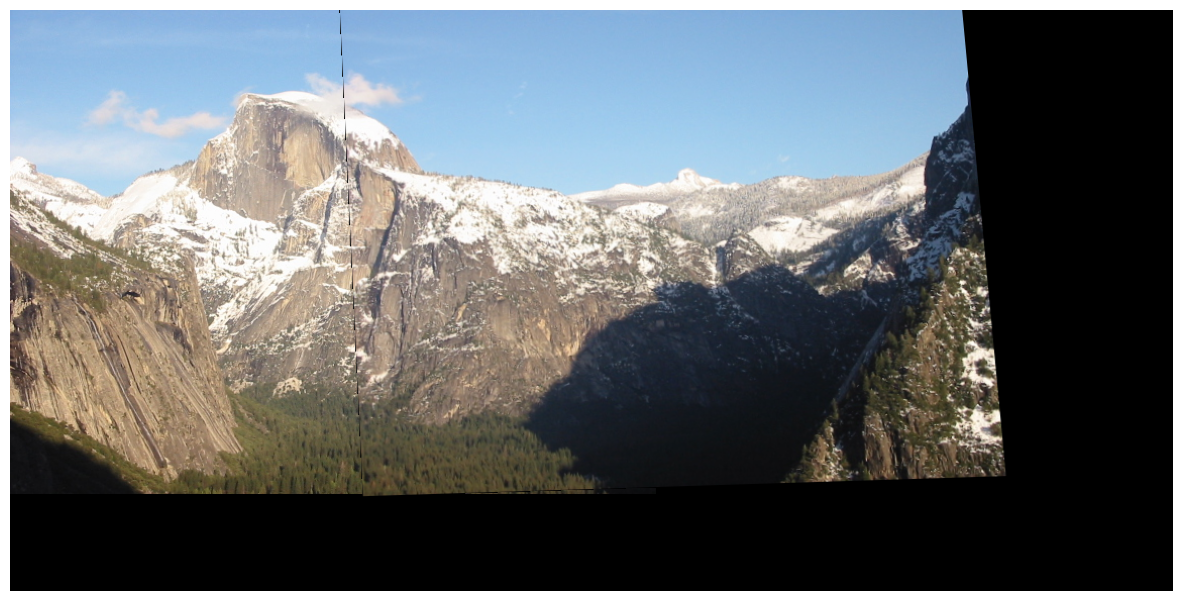

In [169]:
# original_image = img1

# # Define the desired output size
# output_height = 600
# output_width = 800

# # Create a blank canvas of the desired size filled with zeros
# output_image = np.zeros((output_height, output_width, 3))  # Assuming RGB image

# # Calculate the position to place the original image
# x_offset = (output_width - original_image.shape[1]) // 2
# y_offset = (output_height - original_image.shape[0]) // 2

# x_offset = 0
# y_offset = 0
# # Place the original image onto the blank canvas
# output_image[y_offset:y_offset+original_image.shape[0], x_offset:x_offset+original_image.shape[1]] = original_image

# # Display the output image
# plt.imshow(output_image/255)
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(final_image)
plt.axis('off')
fig.savefig("my_result.png", bbox_inches='tight')

In [46]:
# # display and report the stitching results
# # <YOUR CODE>

# cv2.imwrite('stitched_images.jpg', im[:,:,::-1]*255., 
#             [int(cv2.IMWRITE_JPEG_QUALITY), 90])

NameError: name 'im' is not defined

## Extra Credit

In [150]:
img_left = imread("extra_credits/opt_01/park_left.jpg")
img_center = imread("extra_credits/opt_01/park_center.jpg")
img_right = imread("extra_credits/opt_01/park_right.jpg")

In [173]:
data = get_best_matches(img_left, img_center, 3000)
data_test = get_best_matches(img_center, img_left, 3000)

Average residual: 693.7099935669753
Inliers: 688
inliers shape [ True  True  True ... False False False]


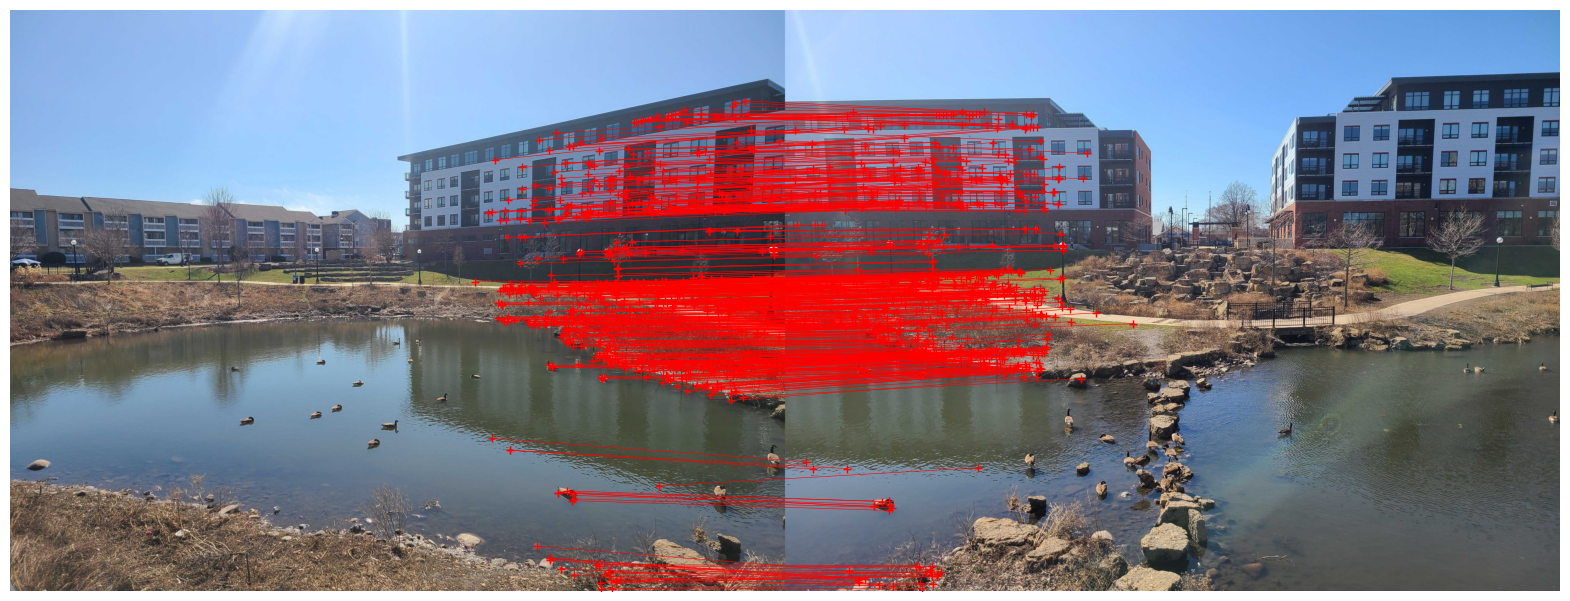

In [183]:
homography, residual, inliers = ransac(data, 5, 85, 0.95, 0.55)
# compute_homography(np.array([1,2,3,4]),np.array([1,2,3,4]),np.array([1,2,3,4]),np.array([1,2,3,4]))

print("Average residual:", np.average(residual))
print("Inliers:", np.sum(inliers))
print("inliers shape", inliers)

fig_ransac, ax_ransac = plt.subplots(figsize=(20,10))

plot_inlier_matches(ax_ransac, img_left, img_center, data[inliers])

(-0.5, 3627.5, 1813.5, -0.5)

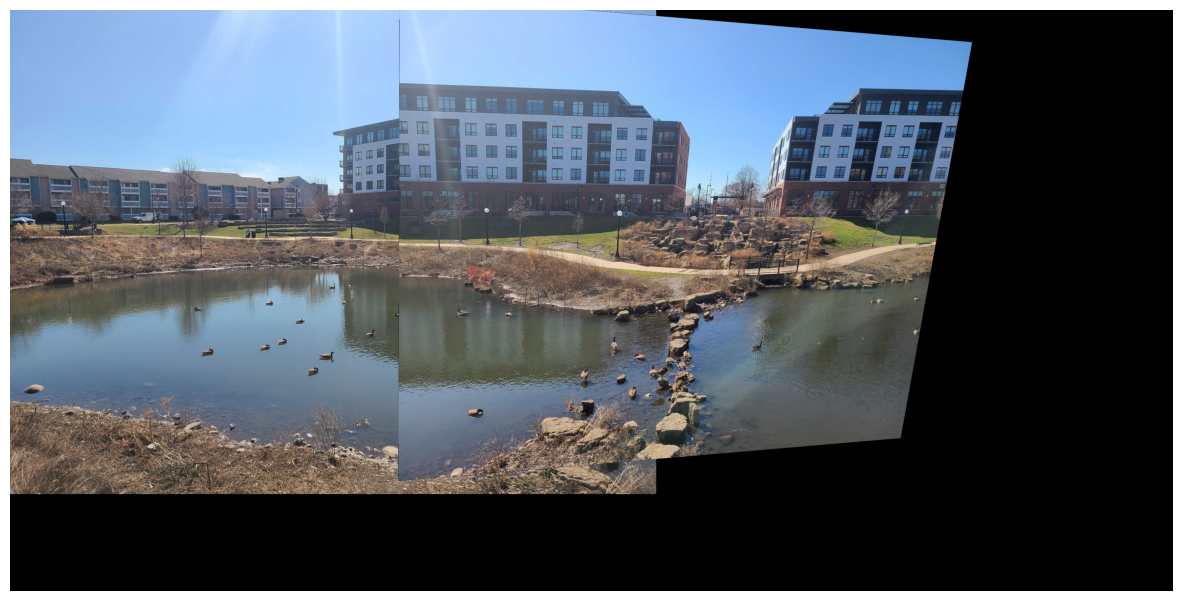

In [185]:
img_left = imread("extra_credits/opt_01/park_left.jpg")
img_center = imread("extra_credits/opt_01/park_center.jpg")

final_img_extra_1 = warp_images(img_left, img_center, homography)

fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(final_img_extra_1)
plt.axis('off')



Average residual: 10168.467771813146
Inliers: 309
inliers shape [False False False ... False False False]


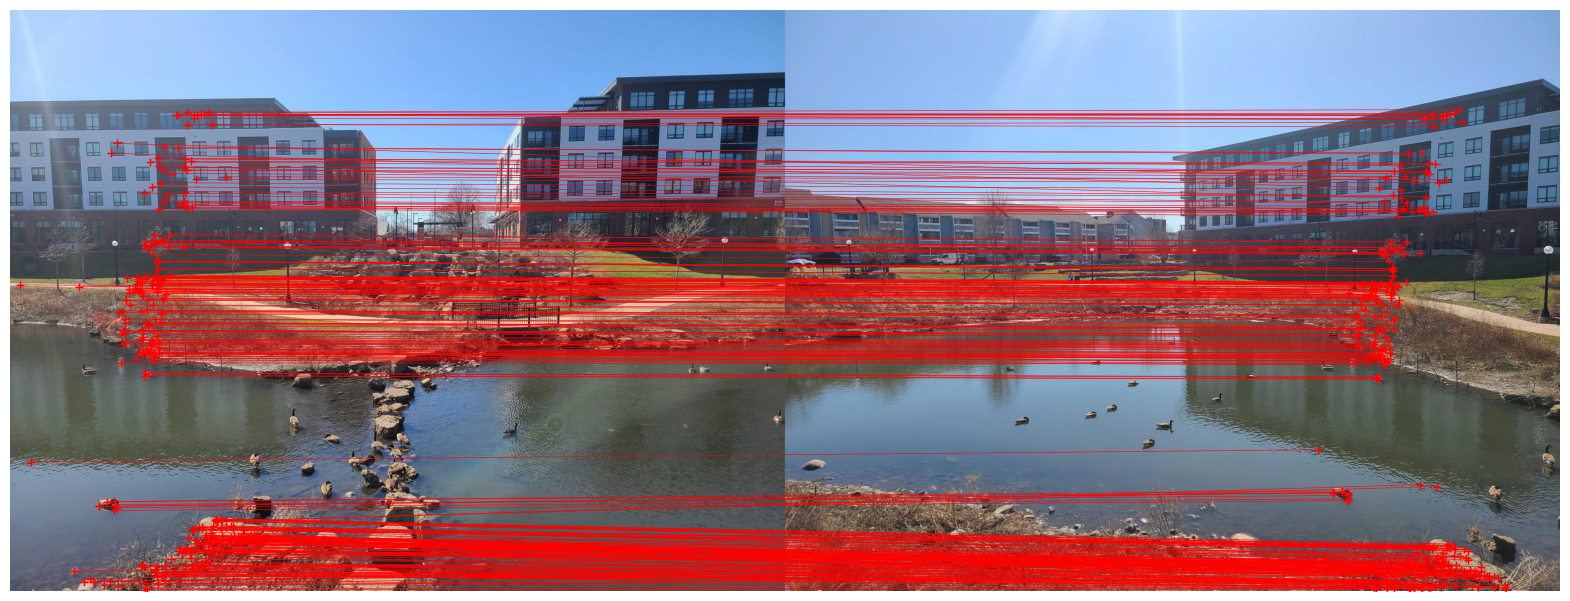

In [179]:
homography, residual, inliers = ransac(data_test, 5, 85, 0.95, 0.55)
# compute_homography(np.array([1,2,3,4]),np.array([1,2,3,4]),np.array([1,2,3,4]),np.array([1,2,3,4]))

print("Average residual:", np.average(residual))
print("Inliers:", np.sum(inliers))
print("inliers shape", inliers)

fig_ransac, ax_ransac = plt.subplots(figsize=(20,10))

plot_inlier_matches(ax_ransac, img_center, img_left, data_test[inliers])

(-0.5, 3627.5, 1813.5, -0.5)

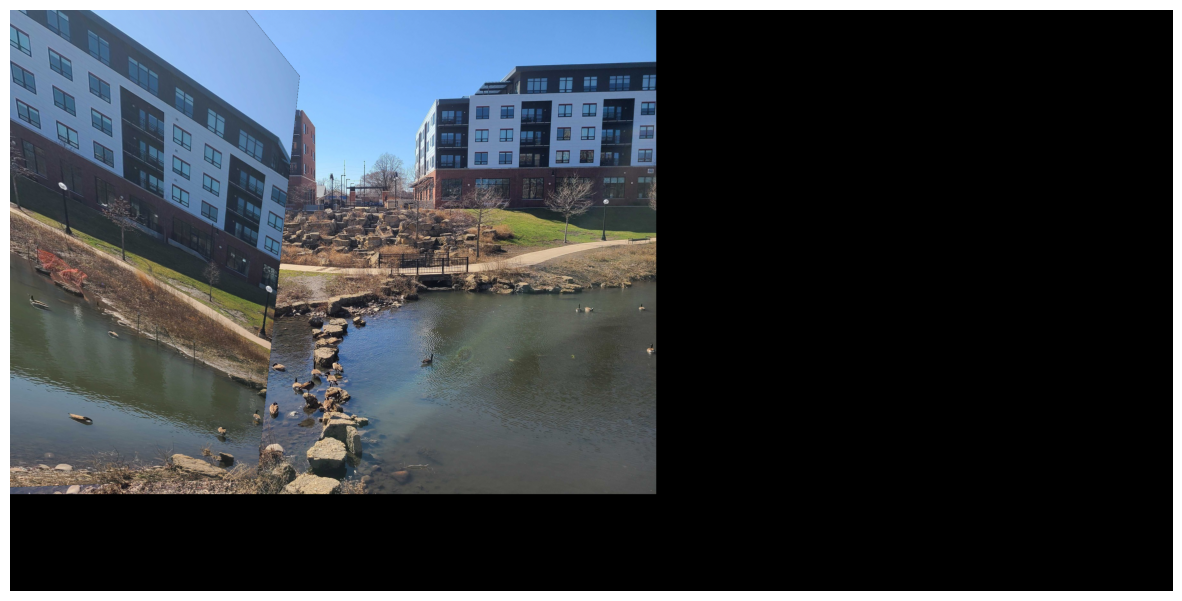

In [181]:
img_left = imread("extra_credits/opt_01/park_left.jpg")
img_center = imread("extra_credits/opt_01/park_center.jpg")

final_img_extra_part2 = warp_images(img_center, img_left, homography)
# new_h = int(img_center.shape[0]*1.5)
# new_w = int(img_center.shape[1]*1.5)

# proj_transform = transform.ProjectiveTransform(np.linalg.inv(homography))
# warped = transform.warp(img_left, proj_transform.inverse, output_shape = (new_h, new_w))

# warped_mask = warped == 0

# new_img1 = np.zeros((new_h, new_w, 3))

# new_img1[:img_center.shape[0]:, new_w - img_center.shape[1]:] = img_center
# img_center_masked = new_img1

# img_center_masked = img_center_masked*warped_mask
# final_img_extra_1 = img_center_masked + warped * 255
# final_img_extra_1 /= 255
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(final_img_extra_part2)
plt.axis('off')
# fig.savefig("my_result.png", bbox_inches='tight')